# Evolutionary Strategies

We will now use evolutionary strategies to optimise values for the Ackley function. Here, we start with an initial guess of the x and y parameters that are not encoded like they were in the GA. This guess is mutated LAMBDA times to generate the next population by adding a random number multiplied by the standard deviation to the current guess. The selected parents in each generation are then used to update the guess by finding the fitness-weighted mean of the parent parameters. Therefore, the only information carried over to the next generation is this single x and y pair that is the current best guess.

## Exercise 3:

- 3.1. Look at the evolutionary strategies code below, what are the primary differences between this algorithm and the GA?
- 3.2. Run the ES with the default parameters and observe the distribution of the population on the [x, y] plot. Compare it to what you saw when running the GA. What do you think causes this difference?
- 3.3. What happens when you change the standard deviation magnitude for the mutation operator, MUTATION_SD? How does it influence the rate of convergence when you have a small vs large magnitude?
- 3.4. Why should the number of parents (MU) be less than the number of children (LAMBDA)? 
- 3.5. How does a large MU/LAMBDA ratio influence the convergence rate?


Generation 0
Best parent: ackley(1.21168,4.351) = 11.32149
Updated m: 1.74055,4.56594


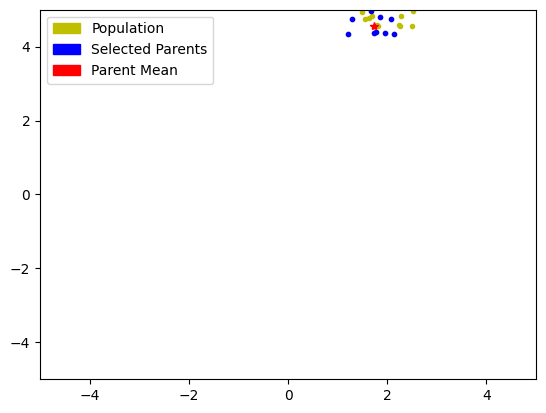

Generation 5
Best parent: ackley(2.00125,3.9979) = 9.37247
Updated m: 1.58549,3.58921


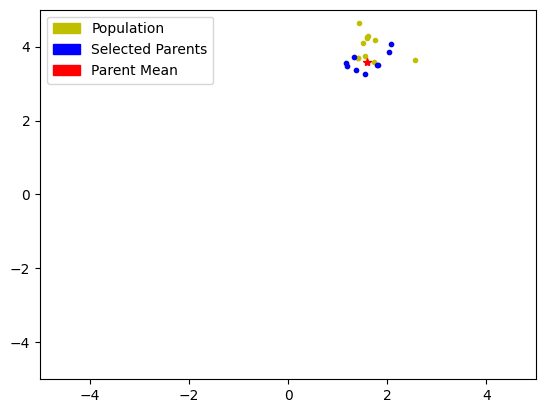

Generation 10
Best parent: ackley(0.95669,2.9815) = 7.21412
Updated m: 1.21986,2.96895


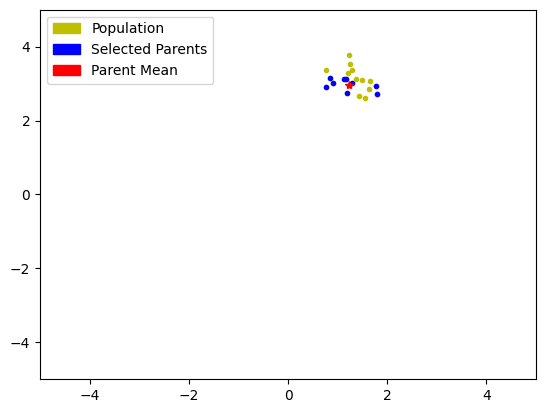

Generation 15
Best parent: ackley(1.23107,2.05872) = 6.78029
Updated m: 0.99357,2.62847


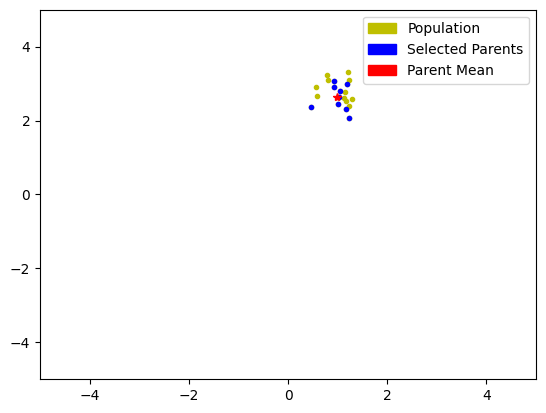

Generation 20
Best parent: ackley(0.93633,1.96306) = 5.43556
Updated m: 0.69851,1.8017


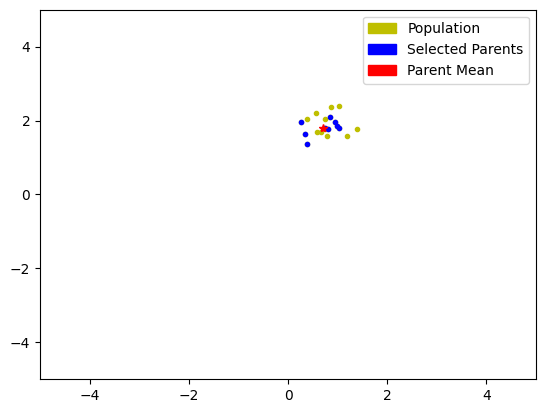

Generation 25
Best parent: ackley(0.10669,0.27162) = 2.14416
Updated m: 0.45662,0.70213


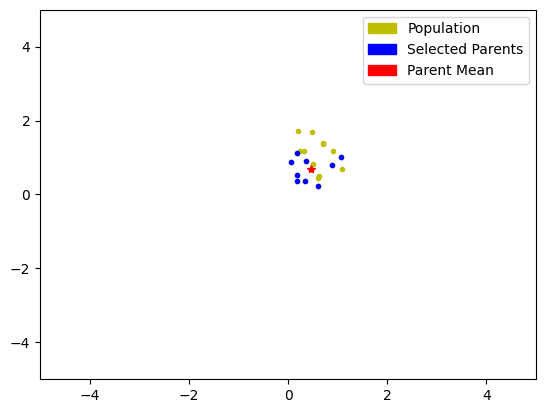

Generation 30
Best parent: ackley(0.01739,0.19414) = 1.30994
Updated m: 0.06214,0.27964


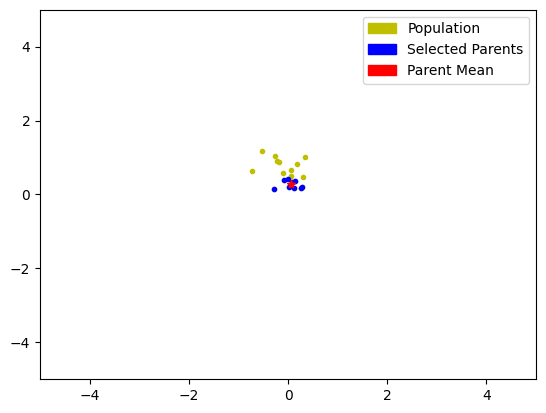

Generation 35
Best parent: ackley(0.04026,-0.01893) = 0.17778
Updated m: 0.08319,0.07409


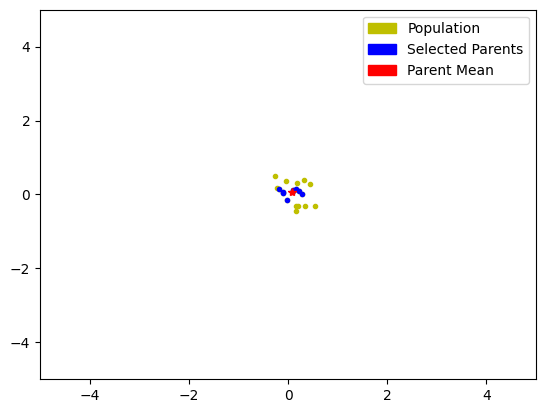

Generation 40
Best parent: ackley(0.00096,-0.00017) = 0.00278
Updated m: -0.01755,-0.00379


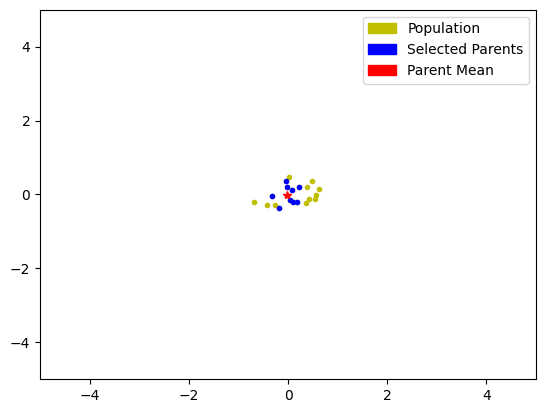

Generation 45
Best parent: ackley(0.00096,-0.00017) = 0.00278
Updated m: -0.04053,-0.11775


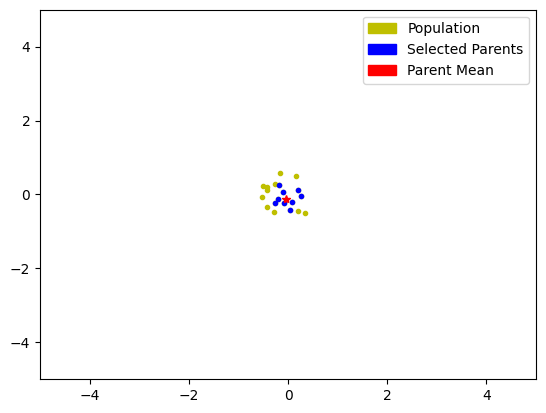

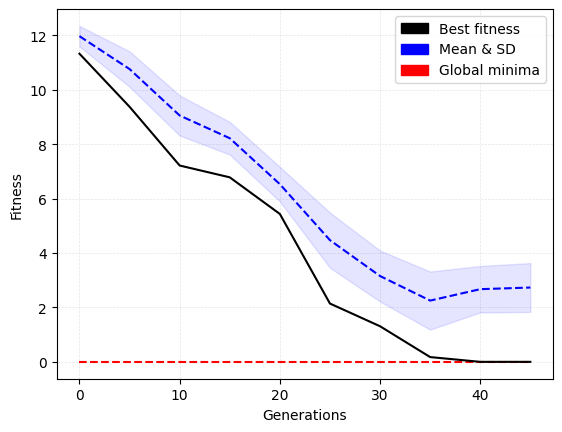

Done!
f([ 0.00095805 -0.0001675 ]) = 0.002776


In [1]:
import numpy as np
import sys
from time import sleep
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


BOUNDS = np.asarray([[-5.0, 5.0], [-5.0, 5.0]])
NUM_ITERATIONS = 50
MUTATION_SD = 0.3 # define the maximum step size
MU = 9 # parents
LAMBDA = 20 # children
STAT_INTERVALS = 5

if MU >= LAMBDA:
    print(f"ERROR: The number of parents (MU) must be less than the number of children (LAMBDA)")
    sys.exit(1)

# ackley function
def ackley(v):
    x, y = v
    return -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x ** 2 + y ** 2))) - np.exp(
        0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + np.e + 20


# check if a point is within the BOUNDS of the search
def in_bounds(point, BOUNDS):
    # enumerate all dimensions of the point
    for d in range(len(BOUNDS)):
        # check if out of BOUNDS for this dimension
        if point[d] < BOUNDS[d, 0] or point[d] > BOUNDS[d, 1]:
            return False
    return True


# evolution strategy
def es(ackley, BOUNDS, NUM_ITERATIONS, MUTATION_SD, MU, LAMBDA):
    best, best_eval = None, 1e+10
    # calculate the number of children per parent
    n_children = int(LAMBDA / MU)
    # initial population
    population = list()
    m = None # initial candidate guess
    while m is None or not in_bounds(m, BOUNDS):
        m = BOUNDS[:, 0] + np.random.rand(len(BOUNDS)) * (BOUNDS[:, 1] - BOUNDS[:, 0])
    # make LAMBDA offspring from m
    for _ in range(LAMBDA):
        candidate = None
        while candidate is None or not in_bounds(candidate, BOUNDS):
            candidate = m + np.random.randn(len(BOUNDS)) * MUTATION_SD
        population.append(candidate)
    # perform the search
    gen_stats = np.empty((0, 3))
    for i in range(NUM_ITERATIONS):
        # evaluate fitness for the population
        scores = [ackley(c) for c in population]
        # rank scores in ascending order
        ranks = np.argsort(np.argsort(scores))
        # select the indexes for the top MU ranked solutions
        selected = [c for c, _ in enumerate(ranks) if ranks[c] < MU]
        #### NORMALISE SCORES
        sum_scores = sum([scores[c] for c in selected])
        # create new m from parents
        m = np.asarray([0., 0.])
        for c in selected:
            # check if this parent is the best solution ever seen
            if scores[c] < best_eval:
                best, best_eval = population[c], scores[c]
            # create new m
            m += (scores[c] / sum_scores) * population[c]
        # make LAMBDA offspring from m
        children = list()
        for _ in range(LAMBDA):
            child = None
            while child is None or not in_bounds(child, BOUNDS):
                child = m + np.random.randn(len(BOUNDS)) * MUTATION_SD
            children.append(child)
            # print information about the current generation
        
        # plot current population and parents
        if i % STAT_INTERVALS == 0:
            gen_stats = np.append(gen_stats, [[best_eval, np.mean(scores), np.std(scores)]], axis=0)
            print(f"Generation {i}\nBest parent: ackley({round(best[0],5)},{round(best[1],5)}) = {round(best_eval,5)}\nUpdated m: {round(m[0],5)},{round(m[1],5)}")
            for i in range(len(population)):
                plt.plot(population[i][0], population[i][1], '.y')
            for i in selected:
                plt.plot(population[i][0], population[i][1], '.b')
            plt.plot(m[0], m[1], '*r')
            plt.xlim([-5, 5])
            plt.ylim([-5, 5])
            y_patch = mpatches.Patch(color='y', hatch=".", label='Population')
            b_patch = mpatches.Patch(color='b', hatch=".", label='Selected Parents')
            r_patch = mpatches.Patch(color='r', hatch="*", label='Parent Mean')
            plt.legend(handles=[y_patch, b_patch, r_patch])
            plt.pause(0.00001)
            plt.close()
            
        population = children
        
    plt.show()
    
    # plot best, mean and standard deviation of the current population
    x_axis_range = list(range(0, gen_stats.shape[0] * STAT_INTERVALS, STAT_INTERVALS))
    plt.plot(x_axis_range, np.zeros(len(x_axis_range)), '--r', linewidth=1.5)
    plt.plot(x_axis_range, gen_stats[:, 0], '-k', linewidth=1.5)
    plt.plot(x_axis_range, gen_stats[:, 1], '--b', linewidth=1.5)
    plt.fill_between(x_axis_range, gen_stats[:, 1] - gen_stats[:, 2], gen_stats[:, 1] + gen_stats[:, 2], color='b', alpha=0.1)
    plt.ylabel("Fitness")
    plt.xlabel("Generations")
    plt.legend(handles=[mpatches.Patch(color='k', label=f"Best fitness"),
                           mpatches.Patch(color='b', label=f"Mean & SD"),
                           mpatches.Patch(color='r', label=f"Global minima")])
    plt.grid(color='k', linestyle='--', linewidth=0.5, alpha=0.1)
    plt.show()
    
    return [best, best_eval]


# perform the evolution strategy (MU, LAMBDA) search
best, score = es(ackley, BOUNDS, NUM_ITERATIONS, MUTATION_SD, MU, LAMBDA)
print('Done!')
print('f(%s) = %f' % (best, score))
